<a href="https://colab.research.google.com/github/lauranorenab/Proyecto_Modelos_2/blob/main/05_Extreme_Gradient_Boosting_Car_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score, KFold, StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_random_state
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import pandas as pd
import numpy as np

# Descripción

Este colab tiene como objetivo explorar la efectividad del modelo de "Extreme Gradient Boostring" en un conjunto de datos desbalanceado y en otro balanceado con la técnica de SMOTE.

# Lectura de los datasets

## Dataset desbalanceado

In [ ]:
df_train_unbalanced = pd.read_csv("df_train_unbalanced.csv")
X_train_unbalanced = df_train_unbalanced.iloc[:, :-1]
y_train_unbalanced = df_train_unbalanced.iloc[:, -1].to_numpy().reshape(len(df_train_unbalanced.iloc[:, -1]),1)

In [ ]:
X_train_unbalanced.shape, y_train_unbalanced.shape

((1382, 6), (1382, 1))

## Dataset balanceado

In [ ]:
df_train_balanced = pd.read_csv("df_train_balanced.csv")
X_train_balanced = df_train_balanced.iloc[:, :-1]
y_train_balanced = df_train_balanced.iloc[:, -1].to_numpy().reshape(len(df_train_balanced.iloc[:, -1]),1)

In [ ]:
X_train_balanced.shape, y_train_balanced.shape

((3872, 6), (3872, 1))

## Dataset para test

In [ ]:
df_test = pd.read_csv("df_test.csv")
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1].to_numpy().reshape(len(df_test.iloc[:, -1]),1)

In [ ]:
X_test.shape, y_test.shape

((346, 6), (346, 1))

# Modelado y validación

## Búsqueda de mejores hiperparámetros

Con el fin de optimizar el rendimiento del modelo, se usó 'GridSearchCV' para ajustar adecuadamente los hiperpárametros del algoritmo. Para este caso, solo evaluaremos los parámetros:
* Min_child_weight
* Max_depth
* Gamma
* Subsample

In [ ]:
# Crear el modelo XGBRegressor
modelXGB = XGBClassifier()

# Se definen los posibles parametros
XGB_param = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    }

scoring = {"Recall": make_scorer(recall_score, average='weighted'),
           "Precision": make_scorer(precision_score, average='weighted', zero_division='warn'),
           "F1-score": make_scorer(f1_score, average='weighted'),
           "Accuracy": make_scorer(accuracy_score),}

## Entrenamiento y predicción

**Después de haber identificado los mejores hiperparámetros para el modelo, procedemos a entrenarlo utilizando tanto el conjunto de datos desbalanceado como el conjunto de datos balanceado.**

### Dataset desbalanceado

In [ ]:
gsearch_xgb_unbalanced = GridSearchCV(
    estimator = modelXGB,
    param_grid = XGB_param,
    cv=5,
    scoring=scoring,
    refit="Recall",
    )

In [ ]:
label_encoder = LabelEncoder()

y_train_encoding = label_encoder.fit_transform(y_train_unbalanced.ravel())
y_train_encoding

array([0, 2, 1, ..., 2, 2, 2])

In [ ]:
gsearch_xgb_unbalanced.fit(X_train_unbalanced, y_train_encoding.ravel())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             refit='Recall',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-score': make_scorer(f1_score, average=weighted),
                      'Precision': make_scorer(precision_score, average=weighted, zero_division=warn),
                      'Recall': make_scorer(recall_score, average=weighted)})

In [ ]:
# Se obtiene el modelo con los mejores hiperparámetros seleccionados
best_model_unbalanced = gsearch_xgb_unbalanced.best_estimator_

# Se realiza la predicción con los datos de test
y_unbalanced_pred = best_model_unbalanced.predict(X_test)

In [ ]:
y_pred_unbalanced = label_encoder.inverse_transform(y_unbalanced_pred).reshape(346, 1)

### Dataset balanceado

In [ ]:
gsearch_xgb_balanced = GridSearchCV(
    estimator = modelXGB,
    param_grid = XGB_param,
    cv=5,
    scoring=scoring,
    refit="Recall",
    )

In [ ]:
label_encoder = LabelEncoder()

y_train_encoding = label_encoder.fit_transform(y_train_balanced.ravel())
y_train_encoding

array([0, 2, 1, ..., 3, 3, 3])

In [ ]:
gsearch_xgb_balanced.fit(X_train_balanced, y_train_encoding.ravel())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             refit='Recall',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-score': make_scorer(f1_score, average=weighted),
                      'Precision': make_scorer(precision_score, average=weighted, zero_division=warn),
                      'Recall': make_scorer(recall_score, average=weighted)})

In [ ]:
# Se obtiene el modelo con los mejores hiperparámetros seleccionados
best_model_balanced = gsearch_xgb_balanced.best_estimator_

# Se realiza la predicción con los datos de test
y_balanced_pred = best_model_balanced.predict(X_test)

In [ ]:
y_pred_balanced = label_encoder.inverse_transform(y_balanced_pred).reshape(346, 1)

## Evaluación de métricas

**Para medir el desempeño del modelo, se utilizaron una variedad de métricas diferentes. Esto se hizo con el fin de tener una visión más general del comportamiento del modelo desde diferentes perspectivas, ya que cada una de las métricas seleccionadas aborda un aspecto especifico del rendimiento del modelo, lo que nos permite realizar una evaluación más completa y precisa de su capacidad predictiva.**

**Las métricas seleccionadas con las siguientes:**


*   **Accuracy:** Representa la proporción de todas las clases correctamente predichas sobre el total de predicciones realizadas para todas las clases.
*   **Recall:** Representa la proporción de instancias positivas reales que fueron correctamente identificadas por el modelo.
*   **Precision:** Proporción de instancias positivas identificadas correctamente por el modelo sobre todas las instancias identificadas como positivas.
*   **F1 Score:** Media armónica de precision y recall. Proporciona una medida balanceada del rendimiento del modelo.

In [ ]:
def show_table(values_train, values_test):
  metricas = ['Recall', 'Precision', 'F1 Score', 'Accuracy']
  df_metricas = pd.DataFrame({'Métrica': metricas, 'Train': values_train, 'Test': values_test})

  return df_metricas

In [ ]:
def compare_metrics(df, ylim_min, train_minor):
  plt.figure(figsize=(6, 6))
  if train_minor:
    sns.barplot(x='Métrica', y='Test', data=df, color='#87FF00', label='Test')
    sns.barplot(x='Métrica', y='Train', data=df, color='#FF0000', alpha=0.8, label='Train')
  else:
    sns.barplot(x='Métrica', y='Train', data=df, color='#FF0000', alpha=0.8, label='Train')
    sns.barplot(x='Métrica', y='Test', data=df, color='#87FF00', label='Test')
  plt.title(f'Comparación de métricas entre Train y Test')
  plt.ylabel('Valor')
  plt.ylim(ylim_min, 1.0)
  plt.xlabel('Métrica')
  plt.legend()

  for bar in plt.gca().patches:
      bar.set_edgecolor('black')  # Establecer el color del borde de la barra
      bar.set_linewidth(1)        # Establecer el grosor del borde de la barra

  plt.show()

In [ ]:
def show_confusion_matrix(model):
  titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
  ]

  class_names = np.unique(y_test)

  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
      model,
      X_test,
      label_encoder.fit_transform(y_test.ravel()),
      display_labels=class_names,
      cmap=plt.cm.Blues,
      normalize=normalize,
    )
    disp.ax_.set_title(title)

  plt.show()

In [ ]:
def compare_indivudual_metrics(y_pred, set):
  classes = np.unique(y_test)
  r_values = []
  p_values = []
  f1_values = []
  for c in classes:
    recall_class = recall_score(y_test, y_pred, labels=[c], average='macro')
    precision_class = precision_score(y_test, y_pred, labels=[c], average='macro')
    f1_class = f1_score(y_test, y_pred, labels=[c], average='macro')
    r_values.append(recall_class)
    p_values.append(precision_class)
    f1_values.append(f1_class)

  print('Recall', r_values)
  print('Precision', p_values)
  print('F1-score', f1_values)

  metrics = {'Recall':r_values, 'Precision':p_values}

  fig, ax = plt.subplots()
  ax.plot(classes, metrics['Recall'], marker = '*', color='#688DFE')
  ax.plot(classes, metrics['Precision'], marker = '*', color='#8CFE68')
  ax.plot(classes, f1_values, marker = '*', color='#FC5050')
  ax.legend(['Recall', 'Precision', 'F1-score'])
  ax.set_title(f'Comparación de Métricas en el conjuto {set}')
  plt.show()

In [ ]:
def show_distribution(y):
    # Crear un diccionario con las etiquetas de clase y el número de muestras por clase
    dicto = dict(zip(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1]))

    # Definir colores distintos para cada barra
    colores = plt.cm.tab10(np.linspace(0, 1, len(dicto)))

    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Generar las barras con colores distintos
    for i, (clase, muestras) in enumerate(dicto.items()):
        ax.bar(clase, muestras, color=colores[i])

    # Configurar título y etiquetas de los ejes
    ax.set_title("Número de muestras por clase")
    ax.set_xlabel("etiqueta de la clase")
    ax.set_ylabel("# muestras por clase")
    ax.set_xticks(list(dicto.keys()))

    # Ocultar los bordes superior y derecho del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

### Dataset desbalanceado

In [ ]:
recall_unbalanced = recall_score(y_true=y_test, y_pred=y_pred_unbalanced, average='weighted')
precision_unbalanced = precision_score(y_true=y_test, y_pred=y_pred_unbalanced, average='weighted')
f1_unbalanced = f1_score(y_true=y_test, y_pred=y_pred_unbalanced, average='weighted')
accuracy_unbalanced = accuracy_score(y_true=y_test, y_pred=y_pred_unbalanced)

In [ ]:
values_test_unbalanced = [recall_unbalanced, precision_unbalanced, f1_unbalanced, accuracy_unbalanced]

In [ ]:
results = gsearch_xgb_unbalanced.cv_results_
best_index = gsearch_xgb_unbalanced.best_index_
values_train_unbalanced = []

for metric in scoring:
  if f"mean_test_{metric}" in results:
      best_score = results[f"mean_test_{metric}"][best_index]
      values_train_unbalanced.append(best_score)
      # print(f"Mejor {metric}: {best_score}")

df_unbalanced = show_table(values_train_unbalanced, values_test_unbalanced)
df_unbalanced

,Métrica,Train,Test
0,Recall,0.980466,0.994220
1,Precision,0.981395,0.994366
2,F1 Score,0.980457,0.994245
3,Accuracy,0.980466,0.994220


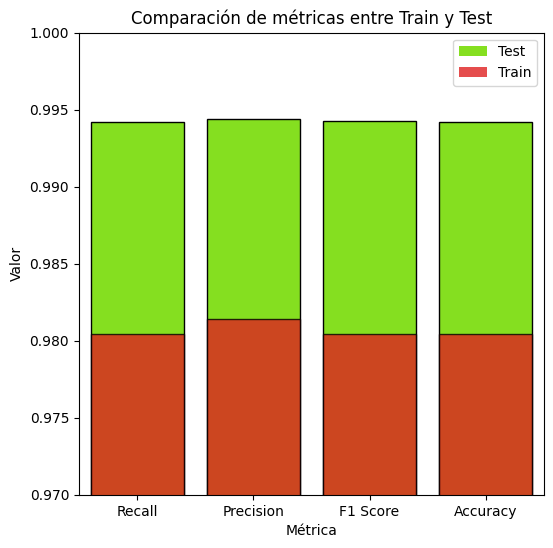

In [ ]:
compare_metrics(df=df_unbalanced, ylim_min=0.97, train_minor=True)

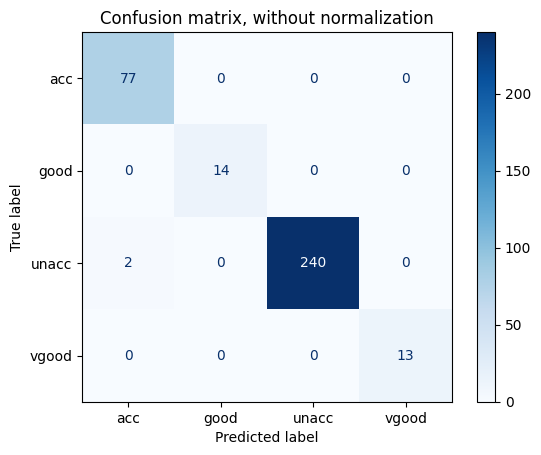

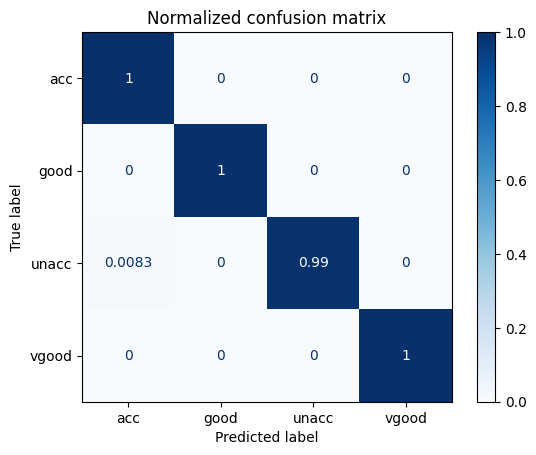

In [ ]:
show_confusion_matrix(best_model_unbalanced)

Recall [1.0, 1.0, 0.9917355371900827, 1.0]
Precision [0.9746835443037974, 1.0, 1.0, 1.0]
F1-score [0.9871794871794872, 1.0, 0.995850622406639, 1.0]


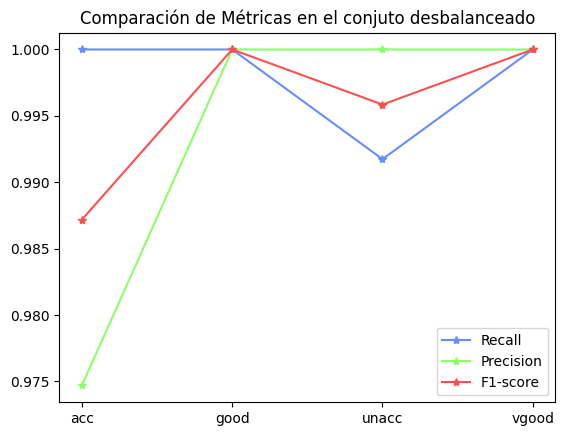

In [ ]:
compare_indivudual_metrics(y_pred=y_pred_unbalanced, set='desbalanceado')

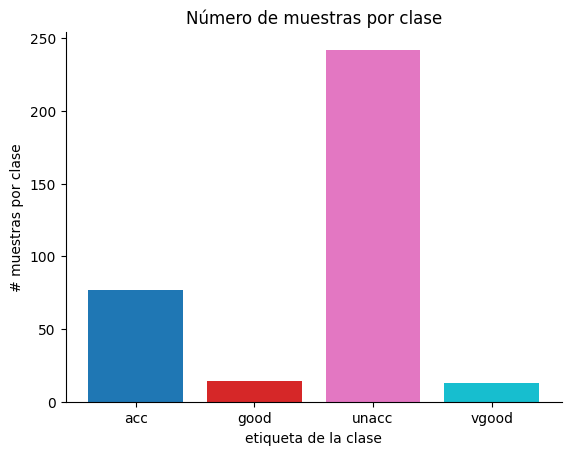

In [ ]:
show_distribution(y_test)

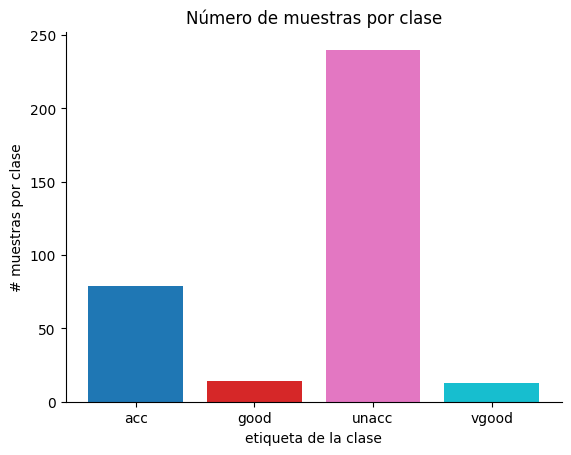

In [ ]:
show_distribution(y_pred_unbalanced)

### Dataset balanceado

In [ ]:
recall_balanced = recall_score(y_true=y_test, y_pred=y_pred_balanced, average='weighted')
precision_balanced = precision_score(y_true=y_test, y_pred=y_pred_balanced, average='weighted')
f1_balanced = f1_score(y_true=y_test, y_pred=y_pred_balanced, average='weighted')
accuracy_balanced = accuracy_score(y_true=y_test, y_pred=y_pred_balanced)

In [ ]:
values_test_balanced = [recall_balanced, precision_balanced, f1_balanced, accuracy_balanced]

In [ ]:
results = gsearch_xgb_balanced.cv_results_
best_index = gsearch_xgb_balanced.best_index_
values_train_balanced = []

for metric in scoring:
  if f"mean_test_{metric}" in results:
      best_score = results[f"mean_test_{metric}"][best_index]
      values_train_balanced.append(best_score)
      # print(f"Mejor {metric}: {best_score}")

df_balanced = show_table(values_train_balanced, values_test_balanced)
df_balanced

,Métrica,Train,Test
0,Recall,0.990443,0.982659
1,Precision,0.990551,0.983674
2,F1 Score,0.990431,0.982878
3,Accuracy,0.990443,0.982659


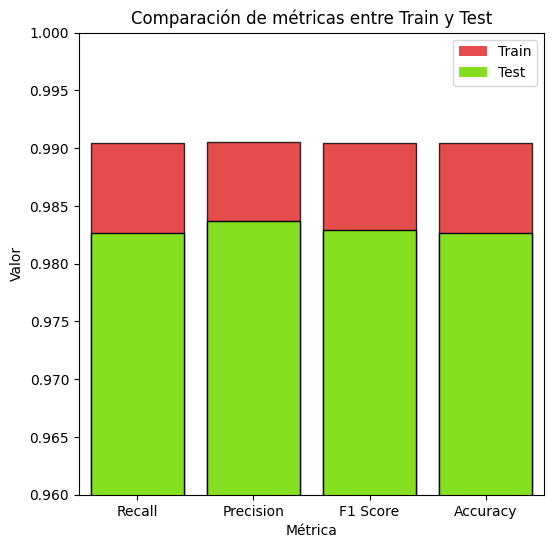

In [ ]:
compare_metrics(df=df_balanced, ylim_min=0.96, train_minor=False)

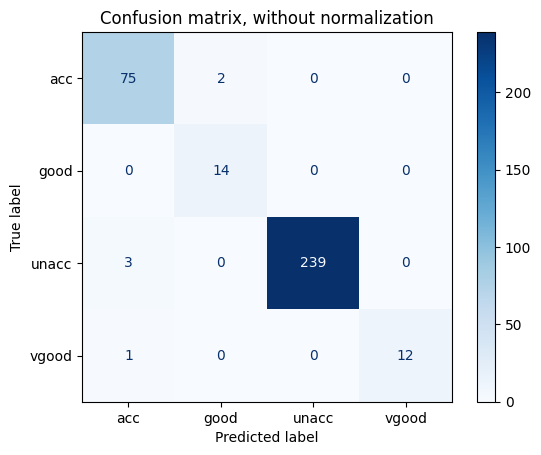

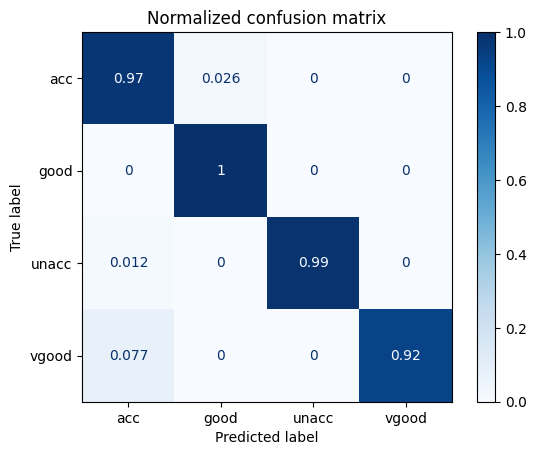

In [ ]:
show_confusion_matrix(best_model_balanced)

Recall [0.974025974025974, 1.0, 0.987603305785124, 0.9230769230769231]
Precision [0.9493670886075949, 0.875, 1.0, 1.0]
F1-score [0.9615384615384615, 0.9333333333333333, 0.9937629937629938, 0.9600000000000001]


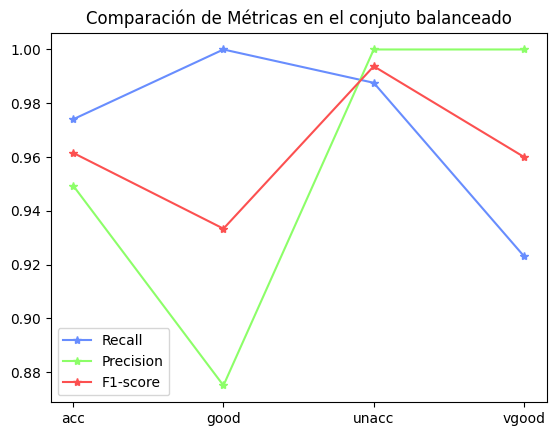

In [ ]:
compare_indivudual_metrics(y_pred=y_pred_balanced, set='balanceado')

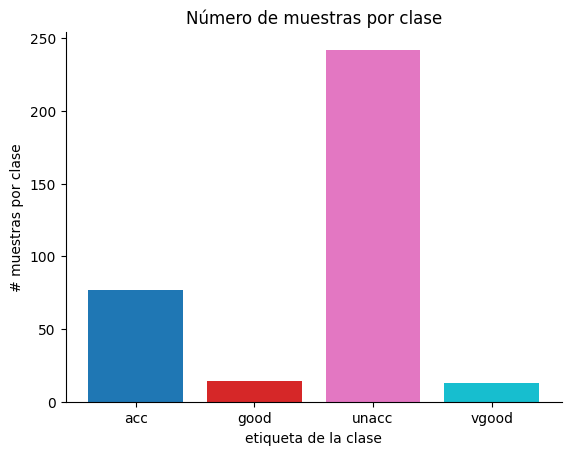

In [ ]:
show_distribution(y_test)

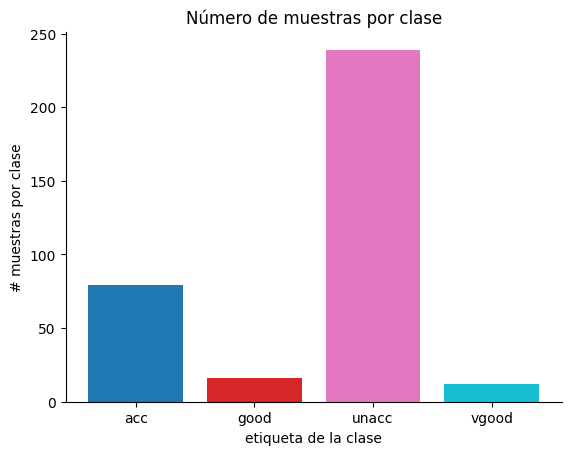

In [ ]:
show_distribution(y_pred_balanced)

# Elección del mejor modelo

In [ ]:
metricas = ['Recall', 'Precision', 'F1 Score', 'Accuracy']

dataset_metrics = pd.DataFrame({'Métrica': metricas, 'Dataset desbalanceado': values_test_unbalanced, 'Dataset balanceado': values_test_balanced})

dataset_metrics

,Métrica,Dataset desbalanceado,Dataset balanceado
0,Recall,0.994220,0.982659
1,Precision,0.994366,0.983674
2,F1 Score,0.994245,0.982878
3,Accuracy,0.994220,0.982659


## Curvas de aprendizaje

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Accuracy")

    # Configura la métrica de precisión
    recall_scorer = make_scorer(recall_score, average='macro')

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=recall_scorer)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training Recall")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation Recall")
    axes.legend(loc="best")

    return plt

**Curva de aprendizaje para el modelo entrenado con el dataset desbalanceado**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

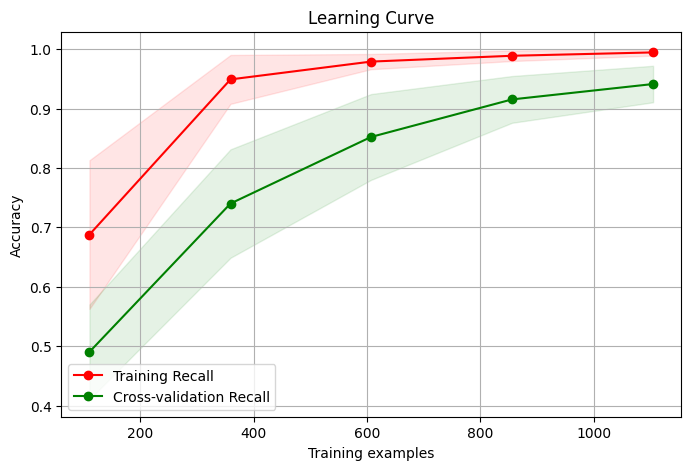

In [ ]:
cv = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

plot_learning_curve(best_model_unbalanced, "Learning Curve", X_train_unbalanced, label_encoder.fit_transform(y_train_unbalanced.ravel()), n_jobs=2, cv=cv)

**Curva de aprendizaje para el modelo entrenado con el dataset balanceado con SMOTE**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

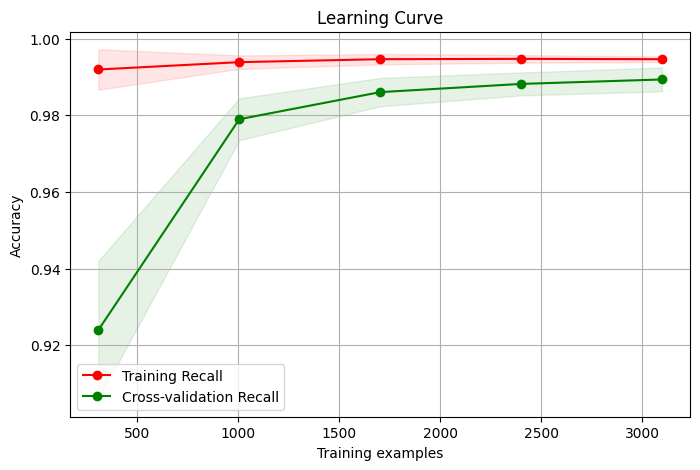

In [ ]:
cv = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

plot_learning_curve(best_model_balanced, "Learning Curve", X_train_balanced, label_encoder.fit_transform(y_train_balanced.ravel()), n_jobs=2, cv=cv)

## **Conclusión**
El modelo entrenado con el dataset balanceado podría considerarse ligeramente superior en términos de concordancia y relación con las clases reales. Por otro lado, esta diferencia es tan pequeña que podríamos considerar que ambos modelos tienen el mismo rendimiento y resultados. Teniendo esto en cuenta esto, optamos por elegir el modelo entrenado con el dataset balanceado debido a la sensibilidad que presentan algunas métricas a los datos desbalanceado, y si bien el Extreme Gradient Boosting es bastante robusto con este tipo de datos, consideramos que la presencia de este riesgo disminuye la confianza en el modelo desbalanceado.